In [63]:
import os
import config as general_paths
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [159]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
input_path = output_path
local_path = general_paths.local_path
# Load human and mouse datasets
human_data_path = data_path + '/human_data/output_file.h5ad'
adata_human = sc.read_h5ad(human_data_path)
sc.pp.scale(adata_human, max_value=10) 
adata_mouse = sc.read_h5ad(os.path.join(input_path , 'campari_scs.h5ad'))
#g_cells = np.logical_or(adata_mouse.obs['stimulus'] == 37,adata_mouse.obs['stimulus'] == 37 )
#adata_mouse = adata_mouse[g_cells,:]


/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [160]:
adata_human.var_names = adata_human.var_names.str.upper()
adata_mouse.var_names = adata_mouse.var_names.str.upper()
# Remove potential version numbers from gene names (e.g., ENSG00000141510.1 -> ENSG00000141510)
adata_human.var_names = adata_human.var_names.str.split('.').str[0]
adata_mouse.var_names = adata_mouse.var_names.str.split('.').str[0]

In [161]:
np.sum(np.isnan(adata_human.X))

0

In [162]:
adata_human.X = adata_human.X + np.finfo(float).eps

In [163]:
np.sum(np.isnan(adata_human.X))

0

In [164]:
# Basic preprocessing for both datasets
#for adata in [adata_human]:
    #sc.pp.filter_cells(adata, min_genes=1)
    #sc.pp.filter_genes(adata, min_counts=1000)
    #sc.pp.filter_genes(adata, min_cells=1)
    #sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata_human)
print(adata_human.X.shape[0]*adata_human.X.shape[1])
print(np.sum(np.isnan(adata_human.X)))
#adata_human.X = adata_human.X + np.finfo(float).eps
#np.nan_to_num(adata_human.X,0)
print(np.sum(np.isnan(adata_human.X)))
#sc.pp.highly_variable_genes(adata_human, flavor = 'seurat', n_top_genes=3000)
#adata_human = adata_human[:, adata_human.var.highly_variable]


23401600
1411553
1411553


/home/melma31/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:384: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [165]:
print(adata_human.X.shape[0]*adata_human.X.shape[1])
print(np.sum(np.isnan(adata_human.X)))
#adata_human.X = adata_human.X + np.finfo(float).eps
np.nan_to_num(adata_human.X,0)
print(np.sum(np.isnan(adata_human.X)))


23401600
1411553
0


In [166]:
import mygene
mg = mygene.MyGeneInfo()

# Human and mouse gene names
human_genes = adata_human.var_names.tolist()
mouse_genes = adata_mouse.var_names.tolist()

# Query for mouse to human homologs
mouse_to_human = mg.querymany(mouse_genes, scopes='symbol', fields='human.gene.symbol', species='mouse')

# Create a dictionary to map mouse genes to human genes
mouse_to_human_dict = {entry['query']: entry.get('human.gene.symbol') for entry in mouse_to_human if 'human.gene.symbol' in entry}

# Similarly, you can do it the other way around if you want to map human genes to mouse genes:
human_to_mouse = mg.querymany(human_genes, scopes='symbol', fields='mouse.gene.symbol', species='human')
human_to_mouse_dict = {entry['query']: entry.get('mouse.gene.symbol') for entry in human_to_mouse if 'mouse.gene.symbol' in entry}


1258 input query terms found dup hits:	[('C730036E19RIK', 2), ('9330185C12RIK', 2), ('GM28410', 2), ('BC035947', 2), ('4933411E06RIK', 2), 
969 input query terms found no hit:	['GM8251', 'ADSS', 'GM9747', 'A530032D15RIK', '9130409I23RIK', 'EPRS', 'FAM126B', 'IQCA', 'BC055324'
2069 input query terms found dup hits:	[('CAMTA1-IT1', 2), ('WASH9P', 2), ('TNFRSF14-AS1', 3), ('MT1XP1', 3), ('ACTG1P20', 2), ('CAMTA1-DT'
217 input query terms found no hit:	['TP73-AS1', 'ZC3H12A-DT', 'PHBP3', 'LINC01135', 'PIFO', 'FLG-AS1', 'FCGR1B', 'C1ORF112', 'GBAP1', '


In [167]:
human_duplicates = adata_human.var_names[adata_human.var_names.duplicated()]
print(f"Duplicated human gene names: {human_duplicates}")

# Check for duplicates in mouse data after renaming
mouse_duplicates = adata_mouse.var_names[adata_mouse.var_names.duplicated()]
print(f"Duplicated mouse gene names: {mouse_duplicates}")

Duplicated human gene names: Index(['POLR2J3', 'TBCE'], dtype='object')
Duplicated mouse gene names: Index([], dtype='object', name='gene_name')


In [168]:
adata_human = adata_human[:, ~adata_human.var_names.duplicated()]
adata_mouse = adata_mouse[:, ~adata_mouse.var_names.duplicated()]

adata_human = adata_human[:, ~adata_human.var_names.duplicated()]
adata_mouse = adata_mouse[:, ~adata_mouse.var_names.duplicated()]

In [169]:
# Map mouse gene names to human gene names
adata_mouse.var_names = [mouse_to_human_dict.get(gene, gene) for gene in adata_mouse.var_names]
# After renaming, find the common genes between human and mouse datasets
common_genes = adata_human.var_names.intersection(adata_mouse.var_names)
# Subset both datasets to include only these common genes
adata_human = adata_human[:, common_genes]
adata_mouse = adata_mouse[:, common_genes]
np.nan_to_num(adata_human.X,0)
print('human data:' + str(adata_human.X.shape))
print('mouse data:' + str(adata_mouse.X.shape))

/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


human data:(1136, 9717)
mouse data:(3343, 9717)


In [170]:
# Assuming adata_human and adata_mouse are already loaded and preprocessed
adata_combined = adata_human.concatenate(adata_mouse, batch_key='species', batch_categories=['human', 'mouse'])

/tmp/ipykernel_55254/891274434.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_human.concatenate(adata_mouse, batch_key='species', batch_categories=['human', 'mouse'])
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

In [171]:
import harmonypy as hm
# Run PCA before Harmony
sc.pp.pca(adata_combined, svd_solver='arpack', n_comps=25)  # You can adjust the number of components
# Run Harmony
harmony_out = hm.run_harmony(adata_combined.obsm['X_pca'], adata_combined.obs, 'species')
adata_combined.obsm['X_pca_harmony'] = harmony_out.Z_corr.T
# Recalculate neighbors with the Harmony-adjusted PCA
sc.pp.neighbors(adata_combined, use_rep='X_pca_harmony')
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined, resolution=1.5)  # Adjust resolution parameter as needed

2024-09-18 12:11:43,906 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-18 12:11:44,415 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-18 12:11:44,425 - harmonypy - INFO - Iteration 1 of 10
2024-09-18 12:11:44,839 - harmonypy - INFO - Iteration 2 of 10
2024-09-18 12:11:45,241 - harmonypy - INFO - Converged after 2 iterations
/home/melma31/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [172]:
# Extract mouse data from combined and ensure it has the correct PCA and UMAP coordinates
adata_mouse_new = adata_combined[adata_combined.obs['species'] == 'mouse']
adata_human = adata_combined[adata_combined.obs['species'] == 'human']


/home/melma31/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


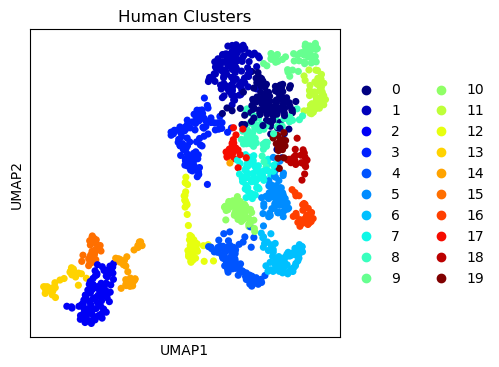

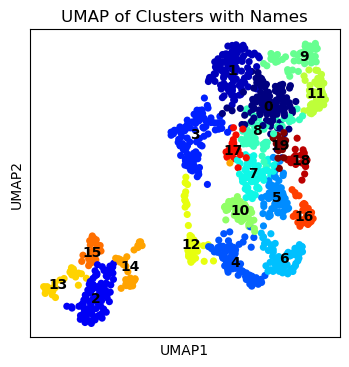

(1136, 9717)

In [173]:
# Perform PCA and clustering on human data only
sc.pp.pca(adata_human, svd_solver='arpack', n_comps=25)  # Adjust number of components if needed
sc.pp.neighbors(adata_human,use_rep = 'X_pca')
sc.tl.umap(adata_human)
sc.tl.leiden(adata_human, resolution=1.5)  # Adjust resolution as needed
# Visualize clusters
sc.pl.umap(adata_human, color='leiden', palette = 'jet',title='Human Clusters',save='umap_clusters_human_leiden.png')
sc.pl.umap(adata_human, color='leiden', legend_loc='on data',  title='UMAP of Clusters with Names')

adata_human.shape

In [174]:
### create and exportable varable list of genes names
from datetime import date
import scipy
today = date.today()

gene_name = []
for i in range(len(adata_human.var['name-human'])):
    gene_name.append(adata_human.var['name-human'].iloc[i])

x = adata_human.X
louvain_names = 'leiden'
louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    louvain[i] = adata_human.obs['leiden'][i]
data = {'umap': adata_human.obsm['X_umap'],'gene_name_matrix' : np.array(gene_name),
        'matrix': x, 'louvain' : louvain, 'louvain_name': louvain_names}

scipy.io.savemat(os.path.join(input_path , 'umap_human_date_'+str(today)+'.mat'), data) ### os.join path  + time so no manual!


#genes_of_interest = ['LXN']

# Generate violin plots for these genes across clusters identified by 'leiden'
#sc.pl.violin(adata_human, keys=genes_of_interest, groupby='louvain', rotation=45)



In [175]:
#sc.tl.rank_genes_groups(adata_human, 'louvain', method='wilcoxon')
#rank_genes_df = pd.DataFrame(adata_human.uns['rank_genes_groups']['names']).head(20)

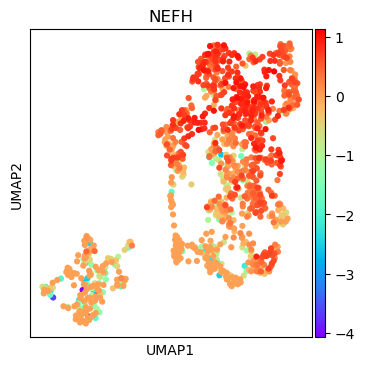

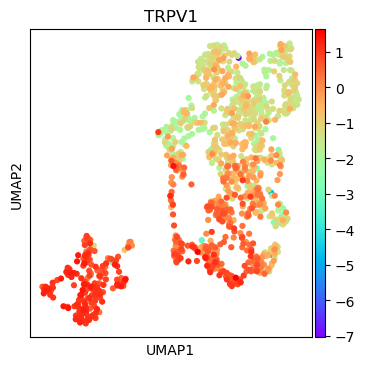

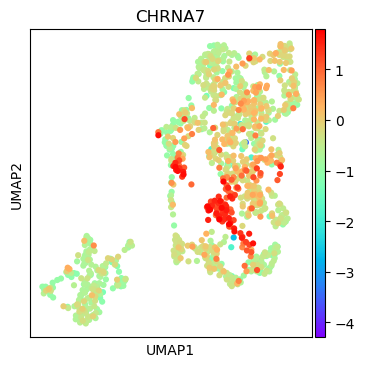

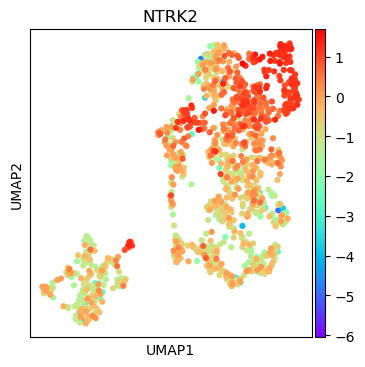

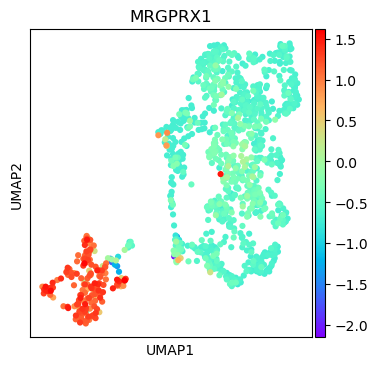

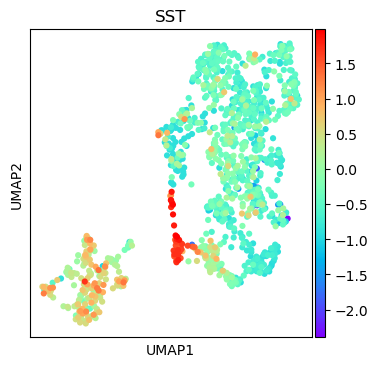

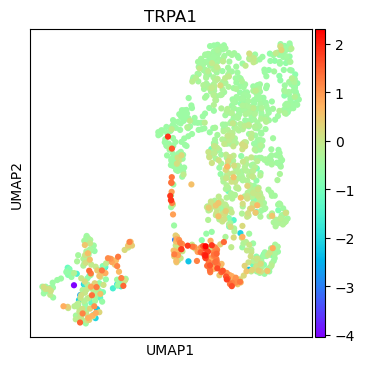

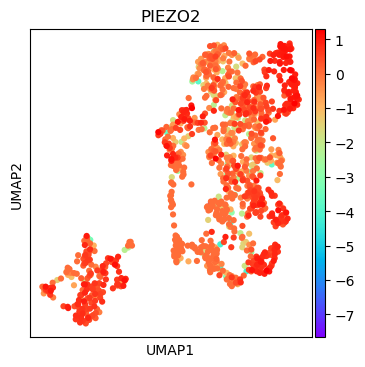

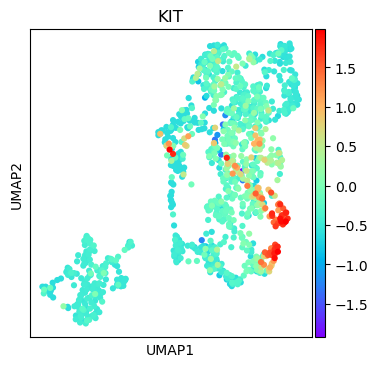

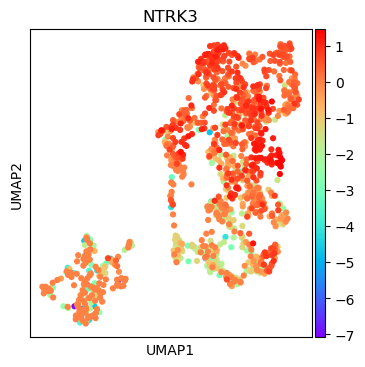

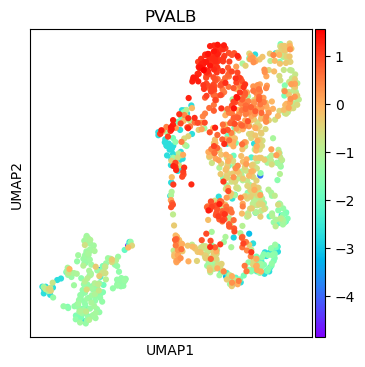

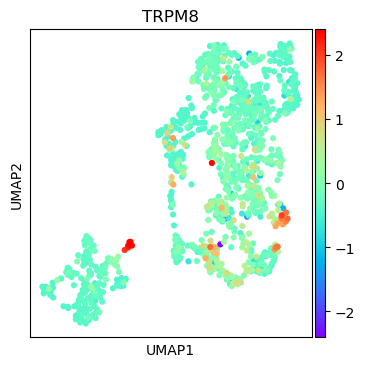

In [176]:
from matplotlib import rcParams

rcParams['figure.figsize']=(4,4)

gene =['NEFH','TRPV1','CHRNA7','NTRK2','MRGPRX1','SST','TRPA1','PIEZO2','KIT','NTRK3','PVALB',"TRPM8"]
#gene = ["SPP1", "NEFH", "S100B", "NEFM", "SPARCL1"]
for gene_name in gene:
    sc.pl.umap(adata=adata_human, color=gene_name, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/human_data/genes_' + gene_name + 'human_data_genes.png', size = 80)

In [177]:
named_clusters = {
    "hTRPM8": ["STUM", "TRPM8", "ENTPD3", "PCDH9", "CA8", "ASIC1"],
    "hCLTMR": ["KCNH6", "SORL1", "CASQ2", "SERPINA1", "P2RY1", "SLIT1"],
    "hNP1": ["AHNAK", "GFRA2", "GPX2", "CDH1", "SCN1A", "MRGPRX1"],
    "hNP2": ["OSMR", "PLCB3", "FSTL1", "RGS4", "IL31RA", "GFRA1"],
    "hSST": ["CEMIP", "IGSF3", "SST", "HTR3A", "GFRA3", "CHRNA3"],
    "hPEPV1/A1.1": ["CALCB", "NOS1", "DGKH", "PCSK1", "CALCA", "TAC1"],
    "hPEPPIEZO": ["SCRG1", "ATP2B4", "TRPA1", "TMBIM1", "SCG2", "AQP1"],
    "hPEPKIT": ["VAT1", "OPRM1", "CD9", "NTRK1", "EHD3", "CAMK1D"],
    "hPEPCHRNA7": ["VAT1L", "PTGER3", "CAPNS3", "NMB", "NGFR", "SERPINE2"],
    "hPEPNTRK3": ["KIT", "TMEM273", "TSPAN33", "DOC2A", "SLC7A14", "BCAM"],
    "hPEP0": ["EXOC1L", "CHRNA7", "CRT3", "CPNE4", "NTRK3", "S100A4"],
    "hAdeltaLTMR": ["ELMO1", "SUSD2", "S100A16", "NPTX1", "CPNE4", "PC4"],
    "hAbetaLTMR": ["LXN", "FABP3", "KCNY1", "PCDH7", "PLXNA2", "KCNAB1"],
    "hProor": ["NTRK2", "RAB31", "HTRA1", "PEMT", "SFRP1", "NEFL"],
    "hATF3": ["SPP1", "NEFH", "S100B", "NEFM", "TECR", "SPARCL1"]
}

hCHRNA7/hPEP0      134
hNP1               133
hPEP0              120
hATF3              113
hProp              112
hAdLTMR            102
hNTRK3              94
hPEP.TRPV1/A1.2     80
hPEP.TRPV1/A1.1     66
hCHRNA7             50
hSST                44
hTRM8               31
hNP2                29
pKIT                28
Name: cluster_names, dtype: int64


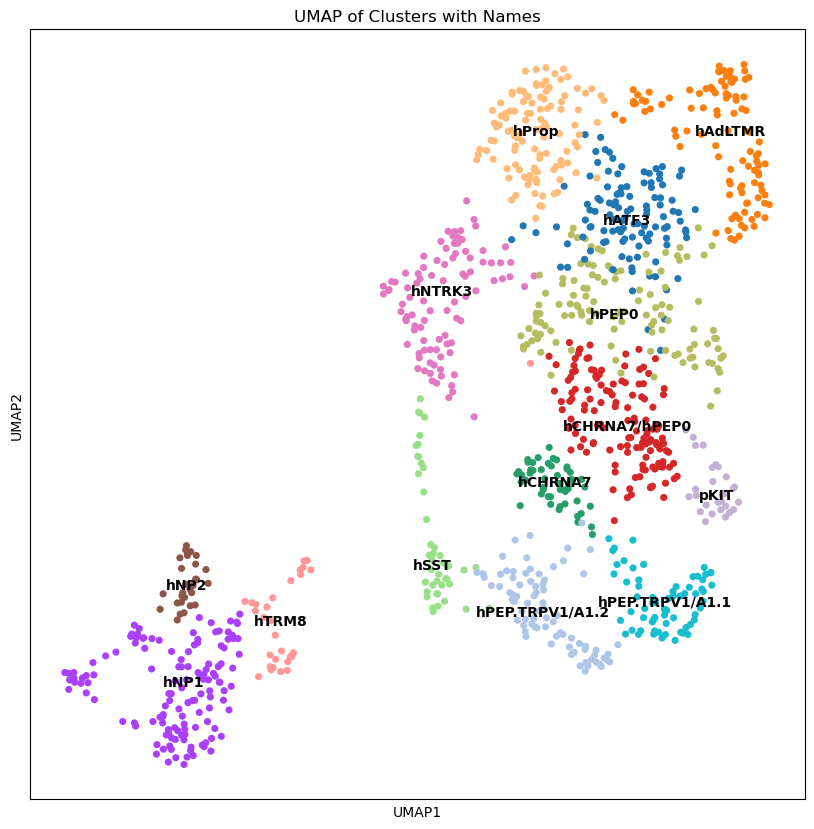

In [178]:
rcParams['figure.figsize']=(10,10)

cluster_names_MANUAL = {
    0: "hATF3",
    1: "hProp",
    2: "hNP1",
    3: "hNTRK3",
    4: "hPEP.TRPV1/A1.2",
    5: "hCHRNA7/hPEP0",
    6: "hPEP.TRPV1/A1.1",
    7: "hCHRNA7/hPEP0",
    8: "hPEP0",
    9: "hAdLTMR",
    10: "hCHRNA7",
    11: "hAdLTMR",
    12: "hSST",
    13: "hNP1",
    14: "hTRM8",
    15: "hNP2",
    16: "pKIT",
    17: "hPEP0",
    18: "hPEP0",
    19: "hPEP0",
}

# Convert leiden labels from strings to integers
adata_human.obs['leiden'] = adata_human.obs['leiden'].astype(int)
# Assuming your cluster labels are in `adata.obs['leiden']` or similar
adata_human.obs['cluster_names'] = adata_human.obs['leiden'].map(cluster_names_MANUAL)
# Check if the mapping worked correctly
print(adata_human.obs['cluster_names'].value_counts())
sc.pl.umap(adata_human, color='cluster_names', legend_loc='on data', title='UMAP of Clusters with Names')

#sc.pl.umap(adata_combined, color=['species', 'leiden', 'transferred_labels'], 
#           title='Combined UMAP with Original and Transferred Labels',
#           legend_loc='on data',save='umap_transfer_cluster_species_leiden_2.png')

In [179]:
#genes_of_interest = ['INA', 'NEFH', 'PRDM12','CALCA','SCN10A']

#genes_of_interest = ['KCNV']
# Generate violin plots for these genes across clusters identified by 'leiden'
#sc.pl.violin(adata_human, keys=genes_of_interest, groupby='louvain', rotation=45)

In [180]:
#gene = ['CHRNA7','TRPM8','NTRK3','PIEZO2','KIT','SST','TRPV1']
#for gene_name in gene:
#    sc.pl.umap(adata=adata_human, color=gene_name, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/human_data/genes_' + gene_name + 'human_data.png', size = 80)

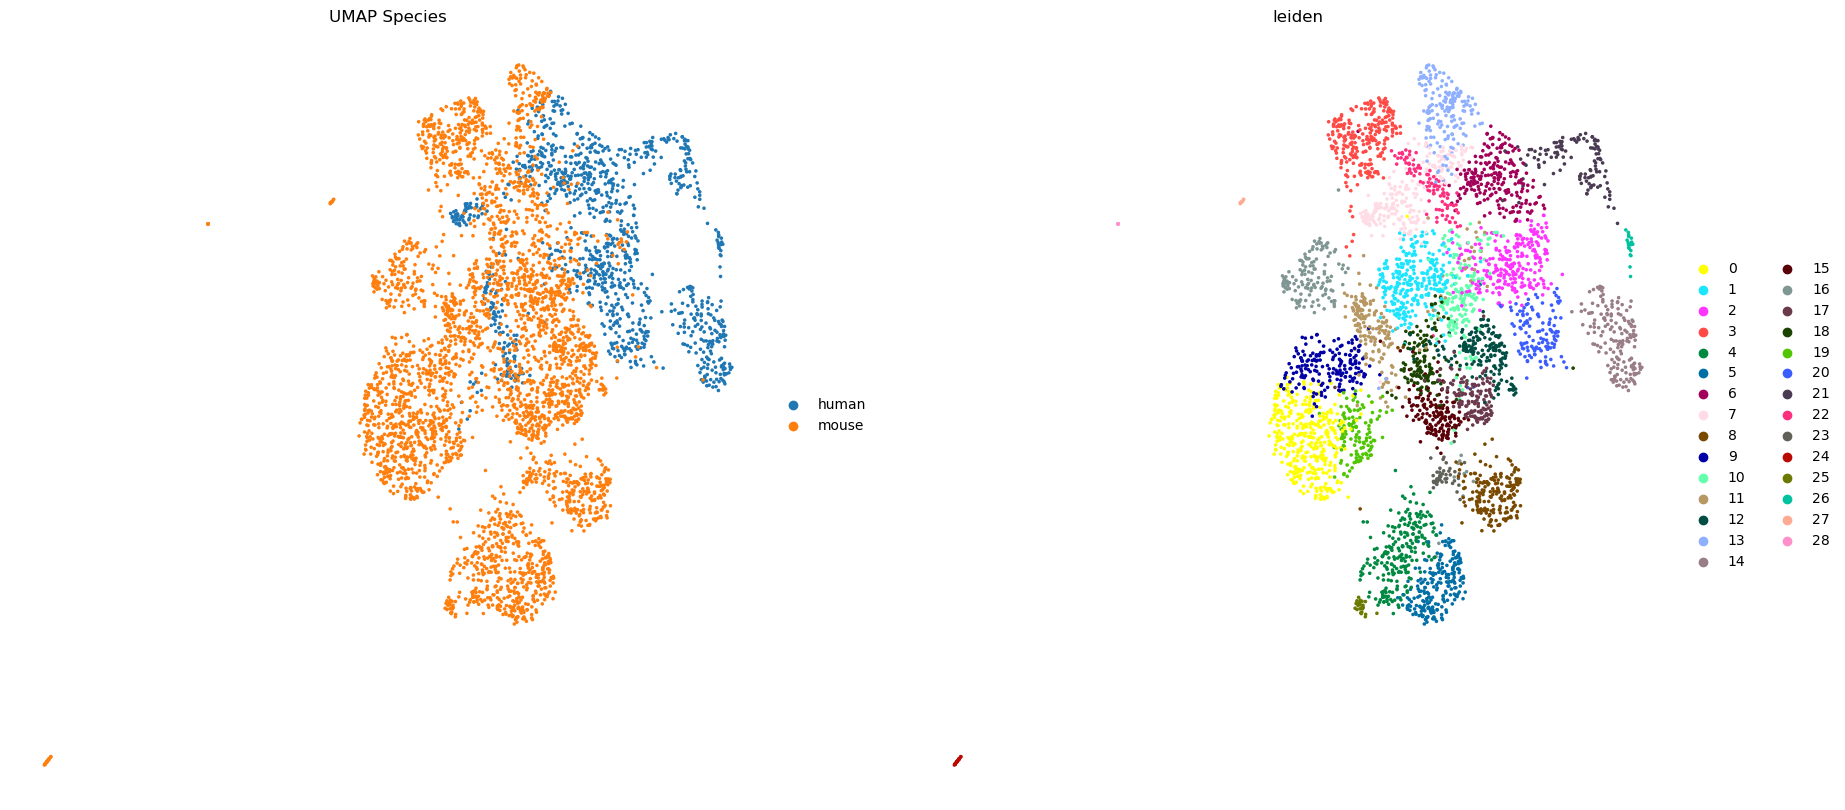

In [181]:

# Visualize UMAP with species and Leiden clustering
#sc.pl.umap(adata_combined, color=['species', 'leiden','cluster_names'], title='UMAP Species',
#           legend_loc='right margin', frameon=False,save='umap_species_leiden_campari_2.png')
sc.pl.umap(adata_combined, color=['species', 'leiden'], title='UMAP Species',
           legend_loc='right margin', frameon=False,save='umap_species_louvain_campari.png')


In [182]:
sc.tl.ingest(adata_mouse_new, adata_human, obs='leiden', embedding_method='umap')


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.


In [183]:
#adata_combined.obs.loc[adata_combined.obs['species'] == 'mouse', 'transferred_labels'] = adata_mouse_new.obs['louvain'].astype(int)
#adata_mouse_new.uns["louvain"] = adata_human.uns["louvain"]  # fix colors
#sc.pl.umap(adata_mouse_new, color=["louvain", "cluster_names"], wspace=0.5)
adata_mouse_new.uns["leiden_colors"] = adata_human.uns["leiden_colors"]  # fix colors
adata_mouse_new.obs['transferred_labels'] = adata_mouse_new.obs['leiden'].astype(int)  # or `.astype(int)`, match your choice
adata_mouse_new.obs['transferred_cluster_names'] = adata_mouse_new.obs['transferred_labels'].map(cluster_names_MANUAL)


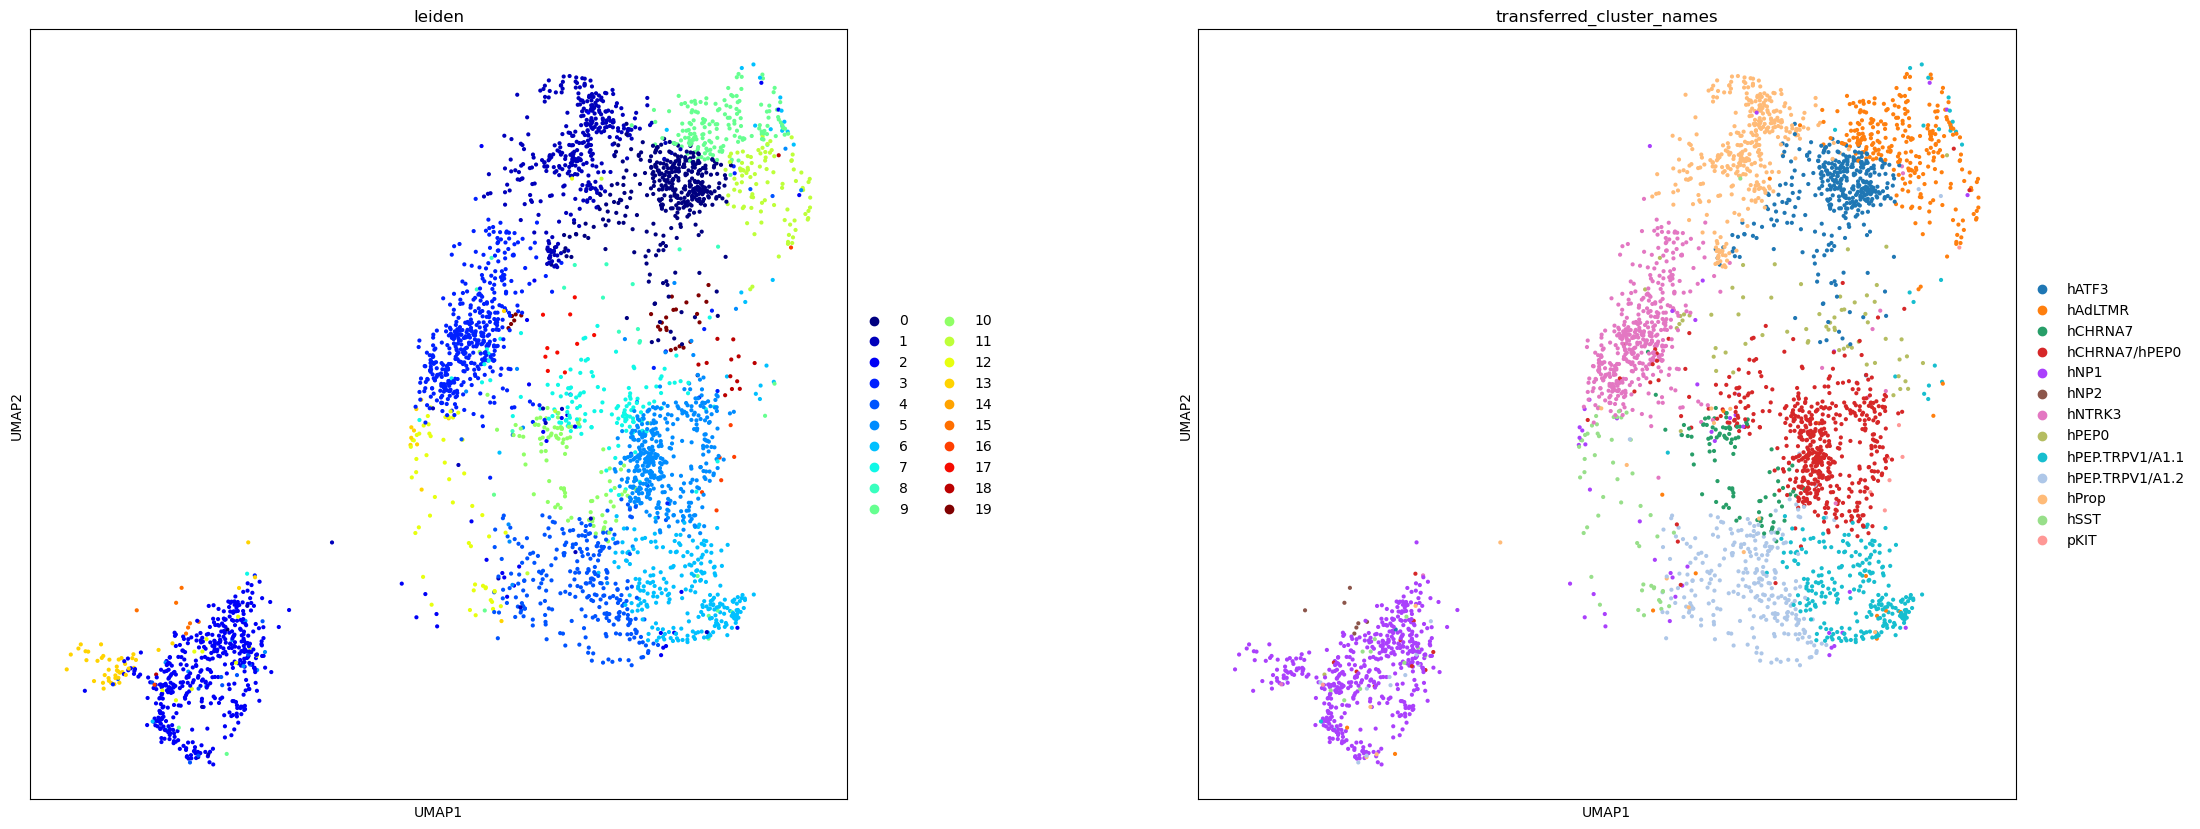

In [184]:
sc.pl.umap(adata_mouse_new, color=["leiden","transferred_cluster_names"], wspace=0.3)


In [185]:
adata_mouse_new.obs['transferred_labels'] = adata_mouse_new.obs['leiden'].astype(int)  # or `.astype(int)`, match your choice


/tmp/ipykernel_55254/2143100981.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata_human.concatenate(adata_mouse_new, batch_categories=["human", "mouse"])
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_name

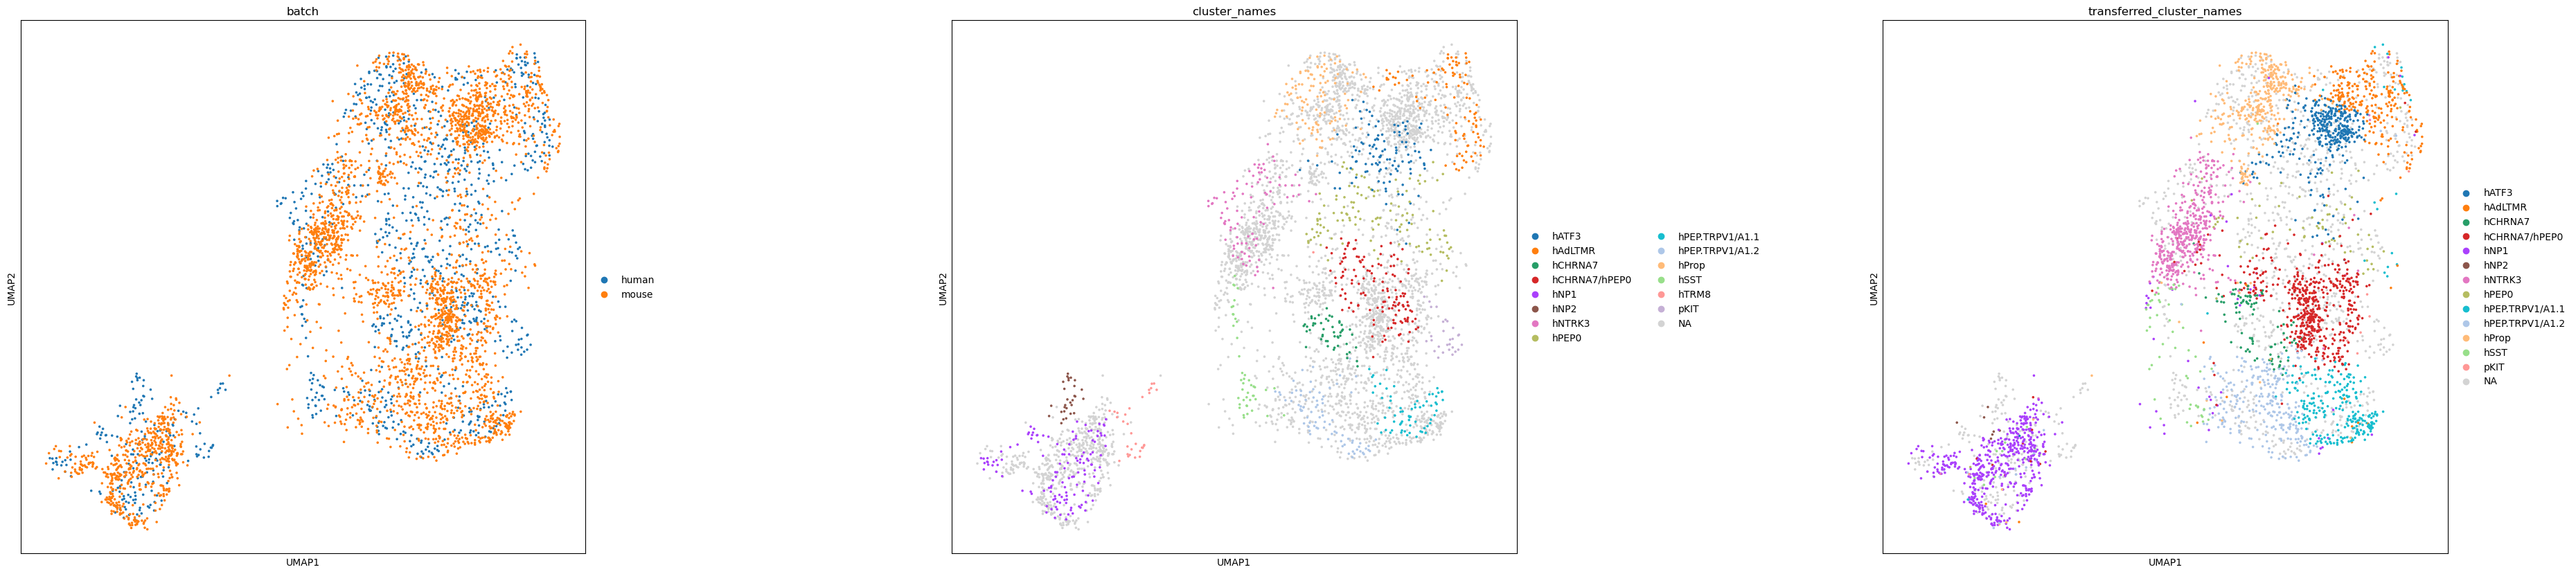

In [186]:
adata_concat = adata_human.concatenate(adata_mouse_new, batch_categories=["human", "mouse"])
adata_concat.obs.leiden = adata_concat.obs.leiden.astype("category")
# fix category ordering
#adata_concat.obs.louvain.cat.reorder_categories(
#    adata_human.obs.louvain.cat.categories, inplace=True
#)
# fix category colors
adata_concat.uns["leiden_colors"] = adata_human.uns["leiden_colors"]
sc.pl.umap(adata_concat, color=["batch", "cluster_names","transferred_cluster_names"], wspace = 0.5)


In [217]:
### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata_concat.var['name-human'])):
    gene_name.append(adata_concat.var['name-human'].iloc[i])
   
gene_name_all = []
for i in range(len(adata_concat.var['name-human'])):
    gene_name_all.append(adata_concat.var['name-human'].iloc[i])
    
x = adata_concat.X
x_all = x.copy()
louvain_names = ['leiden0','leiden2']
louvain = np.zeros((x.shape[0],2))
stimuli = np.zeros((x.shape[0],))
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
cell_id = np.zeros((x.shape[0],))

for i in range(adata_human.X.shape[0]):
    louvain[i,1] = adata_human.obs['leiden'][i]
    stimuli[i] = -1
    red[i] = 0
    green[i] = 0
    cell_id[i] = 0
    
for i in range(adata_human.X.shape[0],adata_concat.X.shape[0]):
    louvain[i,1] = adata_mouse_new.obs['transferred_labels'][i-adata_human.X.shape[0]]
    stimuli[i] = adata_mouse_new.obs['stimulus'][i-adata_human.X.shape[0]]
    red[i] = adata_mouse_new.obs['red'][i-adata_human.X.shape[0]]
    green[i] = adata_mouse_new.obs['green'][i-adata_human.X.shape[0]]
    cell_id[i] = adata_mouse_new.obs['cell_id'][i-adata_human.X.shape[0]]
    
data = {'umap': adata_concat.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),
        'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names, 'cell_id': cell_id}

scipy.io.savemat(os.path.join(input_path , 'umap_humanintegration_date_'+str(today)+'.mat'), data) ### os.join path  + time so no manual!



In [214]:


rcParams['figure.figsize']=(4,4)
gcells = np.logical_or(adata_concat.obs['stimulus']==40,adata_concat.obs['batch'] == 'human')
adata_plot = adata_concat[gcells,:]

1188


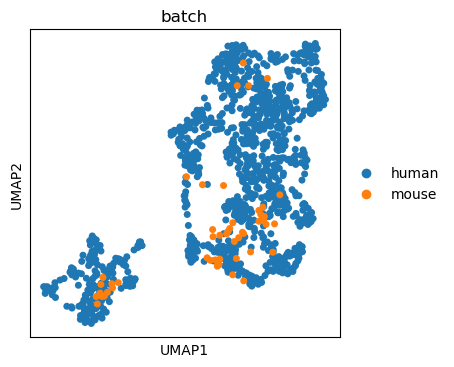

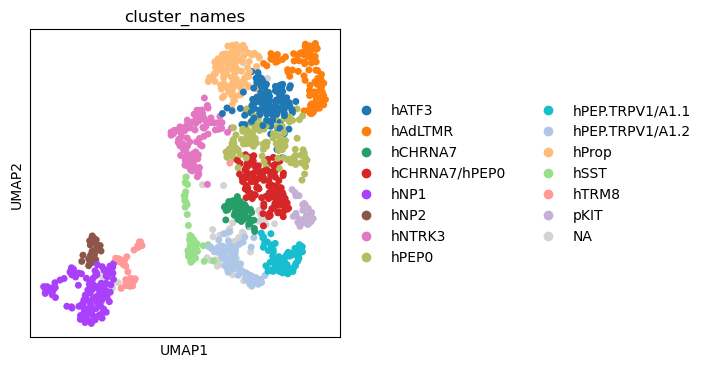

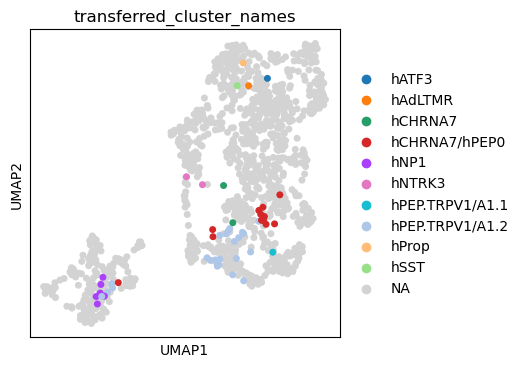

In [215]:
print(len(np.where(gcells)[0]))

sc.pl.umap(adata_plot, color="batch")
sc.pl.umap(adata_plot, color="cluster_names")
sc.pl.umap(adata_plot, color="transferred_cluster_names")




In [ ]:
#!pip install bbknn
sc.external.pp.bbknn(adata_concat, batch_key="batch")  # running bbknn 1.3.6


In [ ]:
sc.tl.umap(adata_concat)


In [ ]:
sc.pl.umap(adata_concat, color=["batch", "cluster_names","transferred_cluster_names"])


In [209]:
adata_concat.obs['batch'] == 'human'

0-human-human                                 True
1-human-human                                 True
2-human-human                                 True
3-human-human                                 True
4-human-human                                 True
                                             ...  
TTAGGCATCCTGGCCTTAAT-sample11-mouse-mouse    False
TCGTGAAGCGCCGGAGCTAA-sample11-mouse-mouse    False
CTGCAAGTGCCGACGCAGAA-sample11-mouse-mouse    False
CCGACGCATTTGGCCTTAAT-sample11-mouse-mouse    False
TAGATCTCTCCCGGAGCTAA-sample11-mouse-mouse    False
Name: batch, Length: 4479, dtype: bool

In [205]:
adata_mouse_new

AnnData object with n_obs × n_vars = 3343 × 9717
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'cell_id', 'batch', 'n_counts', 'log_counts', 'n_genes', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'fraction_mito', 'species', 'leiden', 'transferred_labels', 'transferred_cluster_names'
    var: 'name-human', 'mean-human', 'std-human', 'mean-mouse', 'std-mouse', 'gene_id-mouse', 'gene_name-mouse', 'mt-mouse', 'n_cells_by_counts-mouse', 'mean_counts-mouse', 'pct_dropout_by_counts-mouse', 'total_counts-mouse', 'n_cells-mouse', 'highly_variable-mouse', 'means-mouse', 'dispersions-mouse', 'dispersions_norm-mouse'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'transferred_cluster_names_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'rep'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [216]:
adata_concat.var

,name-human,mean-human,std-human,mean-mouse,std-mouse,gene_id-mouse,gene_name-mouse,mt-mouse,n_cells_by_counts-mouse,mean_counts-mouse,pct_dropout_by_counts-mouse,total_counts-mouse,n_cells-mouse,highly_variable-mouse,means-mouse,dispersions-mouse,dispersions_norm-mouse
TNFRSF18,TNFRSF18,0.006497,0.030479,4.915136e-18,0.033132,Tnfrsf18,Tnfrsf18,False,127,0.049479,96.993371,209.0,96,True,0.004136,0.265526,4.064933
THAP3,THAP3,0.139561,0.178120,2.539930e-16,0.180297,Thap3,Thap3,False,3466,2.785985,17.945076,11768.0,2844,True,0.246894,0.132564,-0.122465
PRDM16,PRDM16,0.027971,0.070134,6.376393e-17,0.105960,Prdm16,Prdm16,False,1841,0.780540,56.415720,3297.0,1451,True,0.067606,0.166362,0.773952
PRKCZ,PRKCZ,0.316172,0.260374,6.673958e-16,0.276602,Prkcz,Prkcz,False,4085,11.695076,3.290720,49400.0,3298,True,0.776004,0.101751,-0.275644
ACAP3,ACAP3,0.195968,0.210332,4.378457e-16,0.244779,Acap3,Acap3,False,3903,5.401752,7.599432,22817.0,3177,True,0.445924,0.138609,0.400680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND3,MT-ND3,2.910286,0.392832,7.311597e-16,0.435680,mt-Nd3,mt-Nd3,True,4071,24.261127,3.622159,102479.0,3267,True,0.908440,0.254627,4.242597
MT-ND4L,MT-ND4L,3.395374,0.434361,6.631449e-16,0.499844,mt-Nd4l,mt-Nd4l,True,4123,82.651752,2.391098,349121.0,3304,True,1.802363,0.190828,3.044176
MT-ND4,MT-ND4,5.114474,0.370985,2.448535e-15,0.371527,mt-Nd4,mt-Nd4,True,4196,137.448864,0.662879,580584.0,3342,True,2.307771,0.142174,1.695485
MT-ND5,MT-ND5,4.186806,0.324372,1.024474e-15,0.327544,mt-Nd5,mt-Nd5,True,4132,55.821970,2.178030,235792.0,3305,True,1.556749,0.152328,1.976956
